In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9035360899062251216
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11516633714263182990
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2):
    return compare_ssim(img1, img2)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [4]:
"""
    load validation data
"""
import gc

dataY = np.zeros((80,512, 512))

for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + ".bmp", cv2.IMREAD_GRAYSCALE)
    dataY[i-1] = img
    
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [5]:
"""
    noise 50%
"""
X_50 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + "_noise50.bmp", cv2.IMREAD_GRAYSCALE)
    X_50[i-1] = img

X_50 = X_50.reshape(-1, 512, 512, 1)
X_50 = X_50.astype('float32') / 255

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_50 ==
loss: 0.005297674797475338
accuracy: 0.03818

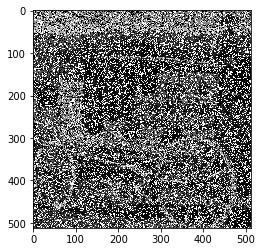

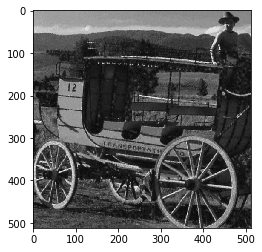

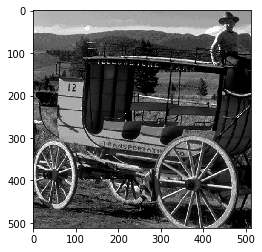

27.350871562957764
27.57409693300724
0.8720088244008276
0.8795322260745346


In [6]:
model = SRCNN("SRCNN_500099.h5")
print("== SRCNN_50 ==")
X_50 = X_50.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_50, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_50)
result = result.reshape(-1, 512, 512)
X_50 = X_50.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_50[18]
plt.imshow(img, cmap="gray")
plt.show()

img = result[18]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[18]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[18], result[18]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
print(totalPSNR / 80)

totalSSIM = 0
print(SSIM(dataY[18], result[18]))
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
print(totalSSIM / 80)

In [7]:
"""
    noise 60%
"""
X_60 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + "_noise60.bmp", cv2.IMREAD_GRAYSCALE)
    X_60[i-1] = img

X_60 = X_60.reshape(-1, 512, 512, 1)
X_60 = X_60.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_60 ==
loss: 0.008347866963595152
accuracy: 0.03616976737976074


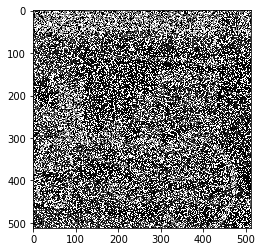

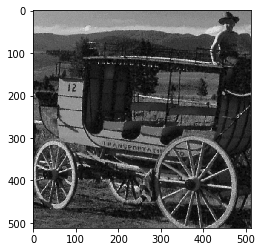

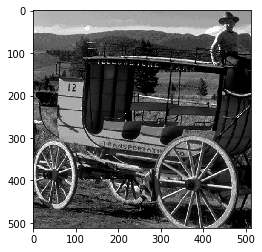

27.31844663619995
26.0349824950099
0.8702056439273523
0.8475489024606537


In [8]:
model = SRCNN("SRCNN_600099.h5")
print("== SRCNN_60 ==")
X_60 = X_60.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_60, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_60)
result = result.reshape(-1, 512, 512)
X_60 = X_60.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_60[18]
plt.imshow(img, cmap="gray")
plt.show()

img = result[18]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[18]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[18], result[18]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
print(totalPSNR / 80)

totalSSIM = 0
print(SSIM(dataY[18], result[18]))
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
print(totalSSIM / 80)

In [9]:
"""
    noise 70%
"""
X_70 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + "_noise70.bmp", cv2.IMREAD_GRAYSCALE)
    X_70[i-1] = img

X_70 = X_70.reshape(-1, 512, 512, 1)
X_70 = X_70.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_70 ==
loss: 0.00993386898189783
accuracy: 0.030403327941894532


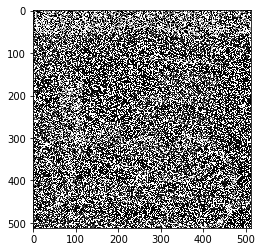

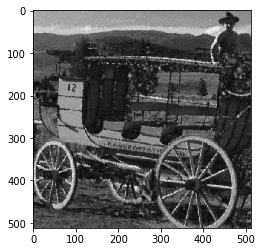

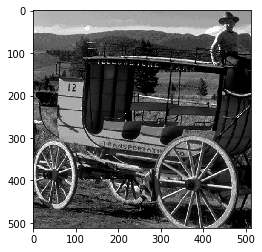

23.58881711959839
24.3011764138937
0.7865914339727389
0.8013703536835903


In [10]:
model = SRCNN("SRCNN_700095.h5")
print("== SRCNN_70 ==")
X_70 = X_70.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_70, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_70)
result = result.reshape(-1, 512, 512)
X_70 = X_70.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_70[18]
plt.imshow(img, cmap="gray")
plt.show()

img = result[18]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[18]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[18], result[18]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
print(totalPSNR / 80)

totalSSIM = 0
print(SSIM(dataY[18], result[18]))
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
print(totalSSIM / 80)

In [11]:
"""
    noise 80%
"""
X_80 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + "_noise80.bmp", cv2.IMREAD_GRAYSCALE)
    X_80[i-1] = img

X_80 = X_80.reshape(-1, 512, 512, 1)
X_80 = X_80.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_80 ==
loss: 0.012100687995553017
accuracy: 0.03174648284912109


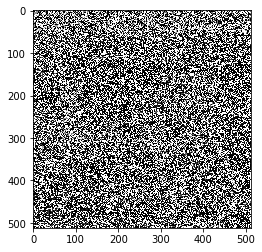

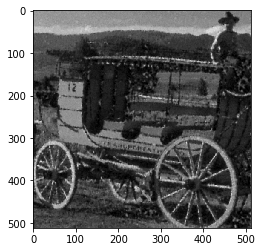

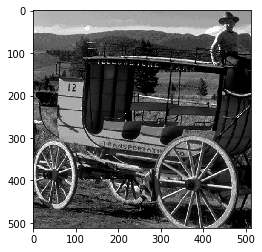

23.446552753448486
23.26792510598898
0.7704853873066243
0.7621294861213838


In [12]:
model = SRCNN("SRCNN_800093.h5")
print("== SRCNN_80 ==")
X_80 = X_80.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_80, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_80)
result = result.reshape(-1, 512, 512)
X_80 = X_80.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_80[18]
plt.imshow(img, cmap="gray")
plt.show()

img = result[18]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[18]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[18], result[18]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
print(totalPSNR / 80)

totalSSIM = 0
print(SSIM(dataY[18], result[18]))
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
print(totalSSIM / 80)

In [13]:
"""
    noise 90%
"""
X_90 = np.zeros((80,512, 512))
for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../512x512(new)/" + picture + "_noise90.bmp", cv2.IMREAD_GRAYSCALE)
    X_90[i-1] = img

X_90 = X_90.reshape(-1, 512, 512, 1)
X_90 = X_90.astype('float32') / 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN_90 ==
loss: 0.017134492471814155
accuracy: 0.030464982986450194


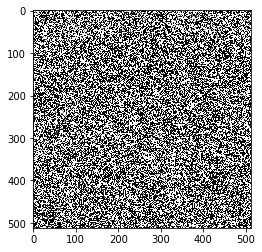

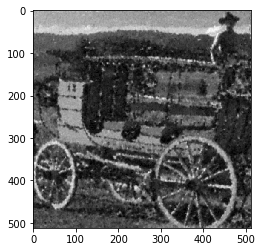

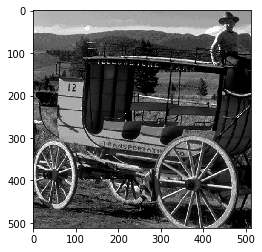

20.4032564163208
21.01767012476921
0.6383184737743814
0.6614529361592647


In [14]:
model = SRCNN("SRCNN_900095.h5")
print("== SRCNN_90 ==")
X_90 = X_90.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X_90, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X_90)
result = result.reshape(-1, 512, 512)
X_90 = X_90.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X_90[18]
plt.imshow(img, cmap="gray")
plt.show()

img = result[18]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[18]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[18], result[18]) )
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(dataY[i], result[i])
print(totalPSNR / 80)

totalSSIM = 0
print(SSIM(dataY[18], result[18]))
for i in range(80):
    totalSSIM += SSIM(dataY[i], result[i])
    #img = result[i]
    #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #cv2.imwrite("../../Denoise/" + str(i+1) + '.png', img)
print(totalSSIM / 80)

In [15]:
print(PSNR(dataY[0], result[0]) )
print(SSIM(dataY[0], result[0]))

21.952719688415527
0.70072578265271
